In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm 

### Context and Objective

A website is conducting an A/B testing experiment to compare the effectiveness of two different button designs. The goal is to determine which design generates a higher user engagement, measured by clicks.

### Objective

The objective is to compare two versions of a button on the Lunar Tech website, where only the button text is changed while everything else remains the same. The aim is to determine if the difference in click-through rates between the experimental and control groups is statistically significant.

**Button Variations**

* Control Group Button: "Secure Free Trial"
* Experimental Group Button: "Enroll Now"

**Null Hypothesis (H<sub>0</sub>):**       P<sub>con</sub> = P<sub>exp</sub>   

**Alternative Hypothesis (H<sub>1</sub>):**   P<sub>con</sub> ≠ P<sub>exp</sub>


### Loading CTR data for AB test

In [2]:
# Loading data from .csv file
df_ab_test = pd.read_csv(r"ab_test_click_data.csv")
df_ab_test.head()

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


In [6]:
print(df_ab_test.describe())

            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000


In [8]:
# Number of clicks for each of the group
df_ab_test[['group','click']].groupby("group").sum("click")

,click
group,
con,1989
exp,6116


A simple bar chart showing the total clicks in each group

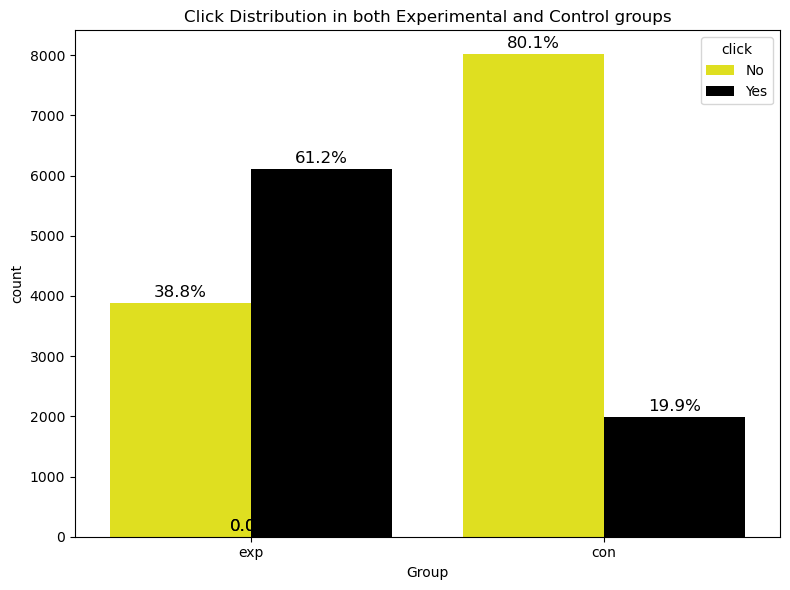

In [36]:
palette = {0: 'yellow' , 1:'black'} 

plt.figure(figsize = (8,6))
ax = sns.countplot(x='group', hue='click', data = df_ab_test, palette =palette)
plt.title("Click Distribution in both Experimental and Control groups")
plt.xlabel('Group')
plt.legend(title="click" , labels=['No','Yes'])

# Calcualte the percentages and annotate the bars
group_counts = df_ab_test['group'].value_counts()
group_click_counts = df_ab_test.groupby(['group','click']).size().reset_index()

for p in ax.patches:
    height = p.get_height()
    # find the group and click type for the current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x()+p.get_width()/2. , height + 100 , f'{percentage:.1f}%',ha = "center", color = "black", fontsize=12)
    
plt.tight_layout()
plt.show()

### Parameters of the Model from Power Analysis

<p style="font-size: 18px;"><b>β:</b> Probability of Type II Error</p>
<p style="font-size: 18px;"><b>(1-β):</b> Power of the test</p>
<p style="font-size: 18px;"><b>α:</b> Probability of Type I Error, Significance Level</p>
<p style="font-size: 18px;"><b>δ:</b> Minimum Detectable Effect</p>


In [37]:
alpha = 0.05 # 5%
print("Alpha: significance level is: ",alpha)

delta = 0.1 # 10%
print("Delta: minimum detectable effect is: ", delta)

Alpha: significance level is:  0.05
Delta: minimum detectable effect is:  0.1


#### Calculating total number of clicks per group by summing up clicks

In [42]:
X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

print(df_ab_test.groupby("group")['click'].sum())
print('control: ', X_con)
print('experimental: ', X_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
control:  1989
experimental:  6116


### Calculating Pooled Estimates for Clicks per Group

In [46]:
#computing the estimate of click probability per group
N_con = df_ab_test['group'].value_counts().loc['con']
N_exp = df_ab_test['group'].value_counts().loc['exp']

p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Click Probability in Control Group:", p_con_hat)
print("Click Probability in Experimental Group:", p_exp_hat)

# computing the estimate of pooled clicked probability
p_pooled_hat = (X_con+X_exp)/(N_con+N_exp)
p_pooled_hat

Click Probability in Control Group: 0.1989
Click Probability in Experimental Group: 0.6116


0.40525

p̂_con = X_con / N_con = #clicks_con / #impressions_con

p̂_exp = X_exp / N_exp = #clicks_exp / #impressions_exp


### Calculating pooled variance

In [57]:
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("p_pooled is: ",p_pooled_hat)
print("pooled varinace is: ", pooled_variance)

p_pooled is:  0.40525
pooled varinace is:  4.82044875e-05


### Calcualting Standard Error and Test Statistics

In [58]:
# computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error is: ", SE)

# computing the test statistics of Z-test
Test_stat = (p_con_hat - p_exp_hat)/SE
print ("Test Statistics for 2-sample Z-test is:", Test_stat) 

# critical value of the Z-test
Z_crit = norm.ppf(1-alpha/2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

Standard Error is:  0.006942945160376826
Test Statistics for 2-sample Z-test is: -59.44163326469381
Z-critical value from Standard Normal distribution:  1.959963984540054


#### Calculating p_values of the Z-test
* A low value (p <= 0.05 at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis.
* A high p-value (p > 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis.

In [59]:
#calculating p value
p_value = 2 * norm.sf(abs(Test_stat))

# function checking the statistical significance
def is_statistical_significance(p_value, alpha):
    """
    We assess whether there is statistical significance based on the p-value and alpha.
    Arguments:
    - p_value (float): The p-value resulting from a statistical test.
    - alpha (float, optional): The significance level threshold used to determine statistical significance. Defaults to 0.05.
    Returns:
    - Prints the assessment of statistical significance.
    """
    # Print the rounded p-value to 3 decimal places
    print(f"P-value of the 2-sample Z-test: {round(p_value, 3)}")
    
    # Determine statistical significance
    if p_value <= alpha:
        print("There is statistical significance, indicating that the observed differences between the groups are unlikely to have occured due to a chance alone.")
    else:
        print("There is no statistical significance, suggesting that the observed differences between the groups could have occurred due to a chance.")

    
is_statistical_significance(p_value, alpha)

P-value of the 2-sample Z-test: 0.0
There is statistical significance, indicating that the observed differences between the groups are unlikely to have occured due to a chance alone.


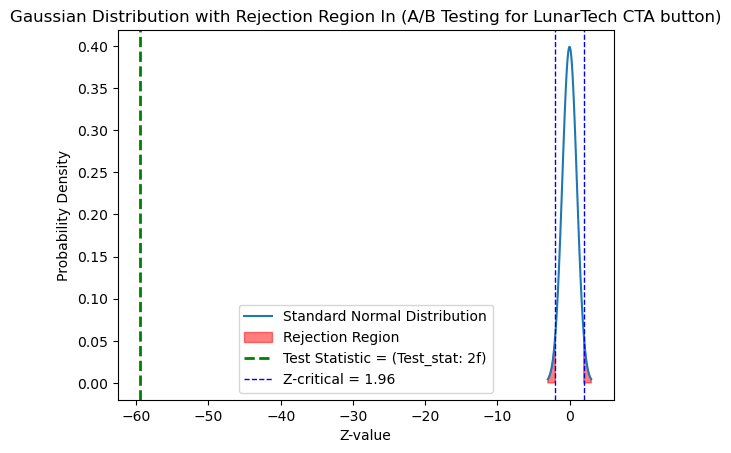

In [66]:
# Parameters for the standard normal distribution
mu = 0 # Mean
sigma = 1
# Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)


# Plotting the standard normal distribution
plt.plot(x, y, label="Standard Normal Distribution")
# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label="Rejection Region")
# Adding Test Statistic
plt. axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = (Test_stat: 2f)')
# Adding Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)
# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel( 'Probability Density')
plt.title( 'Gaussian Distribution with Rejection Region In (A/B Testing for LunarTech CTA button)')
plt.legend( )
# Show plot
plt.show()

### Calcualting the confidence Interval

In [ ]:
# Calculate the Confidence Interval (CI) for a 2-sample Z-test
# Calculate the lower and upper bounds of the confidence interval
round (p-exp hat - -con.hat) = SEa.Crit, 3) Upper bound of the Ci, rounded to 3 decimal places
# Print the calculated confidence interval
print ("Confidence Interval of the 2 sample Z-test is: ", CI)